In [78]:
import numpy as np
import tensorflow as tf
import os, time
import scipy.ndimage
import scipy.misc
import matplotlib.pyplot as plt
from utils import imread, get_patches, imgset_read, imgresize, bicubic_upsize, PS

slim = tf.contrib.slim
%matplotlib inline

In [79]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Dataset


In [80]:
hrImg_t=[]
for i in range(1,6):
    img = imread('images/Set5/HR/img_00'+str(i)+'.png', gray=True)
    hrImg_t.extend(get_patches(img, image_size=32, stride=14))
hrImg = np.array(hrImg_t)
hrImg = np.reshape(hrImg, [hrImg.shape[0], hrImg.shape[1], hrImg.shape[2], 1])
lrImg = imgresize(hrImg, scale=0.25)

# Networks

In [81]:
tf.reset_default_graph()
device = '/gpu:0'

In [82]:
class SRCNN(object):
    def __init__(self, mode):
        self.batch_size = 32
        self.mode = mode

        print('The model is generated')
        
    def model(self, img):
        with slim.arg_scope([slim.conv2d], stride=[1,1], activation_fn = tf.nn.relu, padding='valid',
                                                   weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            self.layer1 = slim.conv2d(inputs=img, num_outputs=64, kernel_size=[9,9], scope='layer1')
            self.layer2 = slim.conv2d(inputs=self.layer1, num_outputs=32, kernel_size=[1,1], scope='layer2')
            self.layer3 = slim.conv2d(inputs=self.layer2, num_outputs=1, kernel_size=[5,5], scope='layer', activation_fn=None)
            out = self.layer3
            model.out_layer=out
        return out
    
    def loss(self, SR, HR):
        loss = tf.reduce_mean(tf.square(SR - HR))
        return loss
    
    def build(self):
        if self.mode == 'bicubic':
            self.LRImg = tf.placeholder(tf.float32, [None, 32, 32, 1], 'LRImgBicubic')
        elif self.mode == 'pixelshuffle':
            self.LRImg = tf.placeholder(tf.float32, [None, 16, 16, 1], 'LRImgPixelShuffle')
        else:
            print ('undefined mode')
        self.HRImg = tf.placeholder(tf.float32, [None, 32, 32, 1], 'HRImg')
        self.SRImg = self.model(self.LRImg)
        self.LOSS = self.loss(self.SRImg, self.HRImg)
        
        self.Fullinput = tf.placeholder(tf.float32, [None, 512,512,1])
        self.FullImg = self.model(self.Fullinput)

In [83]:
with tf.device(device):
    
    model = SRCNN('bicubic')
    model.build()
    lr = tf.placeholder(tf.float32, shape=[])
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(model.LOSS)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config) 
    sess.run(tf.global_variables_initializer())

t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The model is generated
---------
Variables: name (type shape) [size]
---------
layer1/weights:0 (float32_ref 9x9x1x64) [5184, bytes: 20736]
layer1/biases:0 (float32_ref 64) [64, bytes: 256]
layer2/weights:0 (float32_ref 1x1x64x32) [2048, bytes: 8192]
layer2/biases:0 (float32_ref 32) [32, bytes: 128]
layer/weights:0 (float32_ref 5x5x32x1) [800, bytes: 3200]
layer/biases:0 (float32_ref 1) [1, bytes: 4]
Total size of variables: 8129
Total bytes of variables: 32516


(8129, 32516)

In [84]:
train_path='images/train_bicubic_x2/'
label_path='images/train_HR/'

In [85]:

batch_size = 16
total_iter = int(hrImg.shape[0]/batch_size)
epoch_size=100
learning_rate = 1e-6

In [87]:
tf.trainable_variables()[:4]
var_list1 = [variables from first 5 layers]
var_list2 = [the rest of variables]
train_op1 = GradientDescentOptimizer(0.00001).minimize(loss, var_list=var_list1)
train_op2 = GradientDescentOptimizer(0.0001).minimize(loss, var_list=var_list2)
train_op = tf.group(train_op1, train_op2)

[<tf.Variable 'layer1/weights:0' shape=(9, 9, 1, 64) dtype=float32_ref>,
 <tf.Variable 'layer1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layer2/weights:0' shape=(1, 1, 64, 32) dtype=float32_ref>,
 <tf.Variable 'layer2/biases:0' shape=(32,) dtype=float32_ref>]

In [13]:
for epoch in range(epoch_size):
    avg_psnr = 0
    cnt = 0
    start_time=time.time()
    for i in range(total_iter):
        index = np.random.choice(hrImg.shape[0], batch_size, replace=False)
        HRImg = hrImg[index]
        LRImg = imgresize(lrImg[index], scale=4)

        _, loss = sess.run([optm, model.LOSS], feed_dict={model.LRImg:LRImg, model.HRImg:HRImg, lr:learning_rate})

        psnr = 20*np.log10(1./(np.sqrt(loss)))
        if psnr==psnr:  #check NaN
            avg_psnr += psnr
            cnt+=1

        print ("\ri: {}/{} ({:.1f}%) psnr: {:.5f}".format(i, total_iter, i*100/total_iter, psnr), end="")


    print ('\repoch: %3d, avg_PSNR: %4f, time for epoch: %.2f' %(epoch, avg_psnr/cnt, time.time()-start_time))

    #mg = sess.run(model.out_layer, feed_dict={LRImg: train_image})
    #or j in range(img.shape[0]):
    #   imsave(img[j,:,:,0], 'results/srcnn'+str(j).zfill(4)+'.png')
    #   imsave(train_image[j,:,:,0], 'results/interpol_'+str(j).zfill(4)+'.png')



epoch:   0, avg_PSNR: 26.762426, time for epoch: 0.46
epoch:   1, avg_PSNR: 26.795494, time for epoch: 0.48
epoch:   2, avg_PSNR: 26.787760, time for epoch: 0.48
epoch:   3, avg_PSNR: 26.562521, time for epoch: 0.49
epoch:   4, avg_PSNR: 26.751671, time for epoch: 0.48
epoch:   5, avg_PSNR: 26.533296, time for epoch: 0.48
epoch:   6, avg_PSNR: 26.488361, time for epoch: 0.48
epoch:   7, avg_PSNR: 26.699565, time for epoch: 0.47
epoch:   8, avg_PSNR: 26.385173, time for epoch: 0.48
epoch:   9, avg_PSNR: 26.406810, time for epoch: 0.47
epoch:  10, avg_PSNR: 26.606682, time for epoch: 0.47
epoch:  11, avg_PSNR: 26.819883, time for epoch: 0.48
epoch:  12, avg_PSNR: 26.590702, time for epoch: 0.48
epoch:  13, avg_PSNR: 26.737001, time for epoch: 0.48
epoch:  14, avg_PSNR: 26.603406, time for epoch: 0.48
epoch:  15, avg_PSNR: 26.779668, time for epoch: 0.48
epoch:  16, avg_PSNR: 26.899892, time for epoch: 0.48
epoch:  17, avg_PSNR: 26.645769, time for epoch: 0.48
epoch:  18, avg_PSNR: 26.627

In [10]:
saver=tf.train.Saver()

In [53]:

saver.save(sess, 'checkpoints/SRCNN/Set5/x2_psnr_37-39')

'checkpoints/SRCNN/Set5/x2_psnr_37-39'

In [11]:
saver.restore(sess,'checkpoints/SRCNN/Set5/x2_psnr_37-39')


INFO:tensorflow:Restoring parameters from checkpoints/SRCNN/Set5/x2_psnr_37-39


In [70]:
fullimage = np.reshape(imread('images/Set5/HR/img_001.png', gray=True), [1,512,512,1])
fulllrimage = np.reshape(imread('images/Set5/image_SRF_2/img_001_SRF_2_bicubic.png', gray=True), [1,512,512,1])
outimage = sess.run(model.FullImg, feed_dict={model.Fullinput:fulllrimage})


In [71]:
IMAGE = np.concatenate([fullimage[0,:,:,0], fulllrimage[0,:,:,0], outimage[0,:,:,0]], axis=1)
IMAGE2= np.concatenate([fullimage[0,150:250,100:200,0], fulllrimage[0,150:250,100:200,0], outimage[0,150:250,100:200,0]], axis=1)

(-0.5, 299.5, 99.5, -0.5)

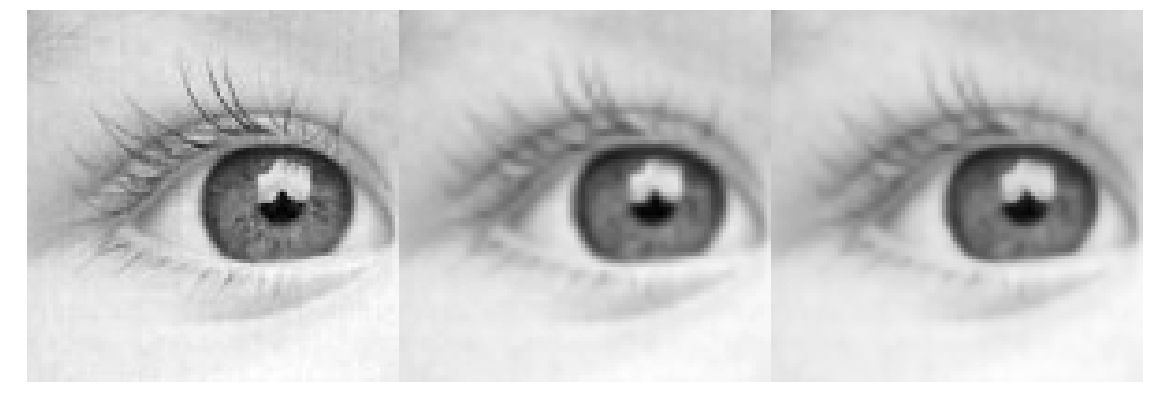

In [72]:
plt.figure(figsize=[20,10])
plt.imshow(IMAGE2, cmap='gray')
plt.axis('off')

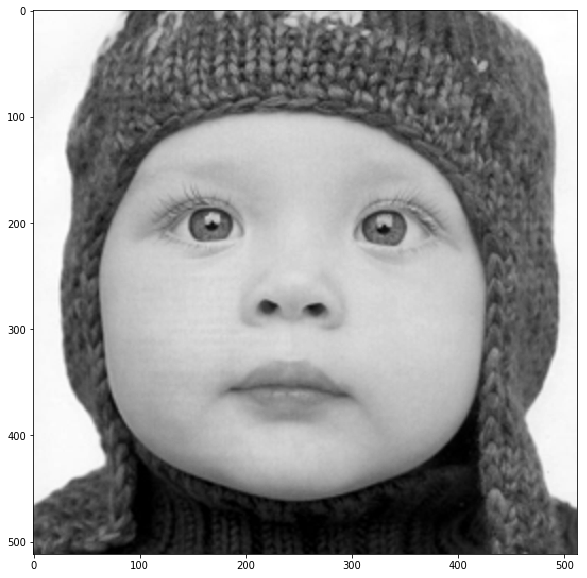

In [73]:
plt.figure(figsize=[10,10])
plt.imshow(fulllrimage[0,:,:,0], cmap='gray')

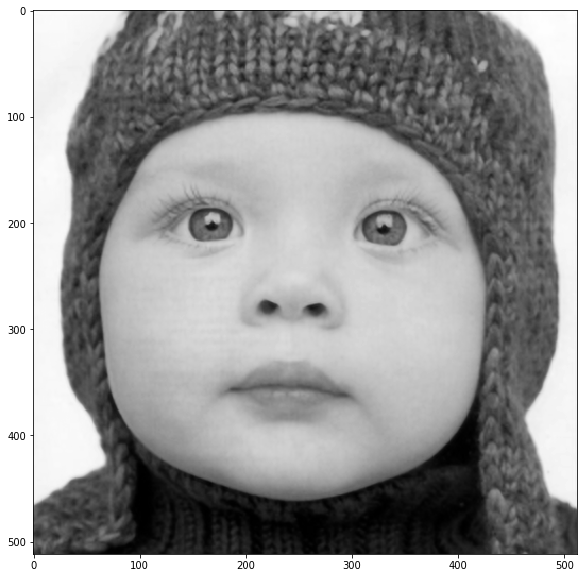

In [74]:
plt.figure(figsize=[10,10])
plt.imshow(outimage[0,:,:,0], cmap='gray')

In [77]:
20*np.log10(1./(np.sqrt(np.mean(np.square(fulllrimage[0,10:-10,10:-10,0]-fullimage[0,10:-10,10:-10,0])))))

35.59682176420657

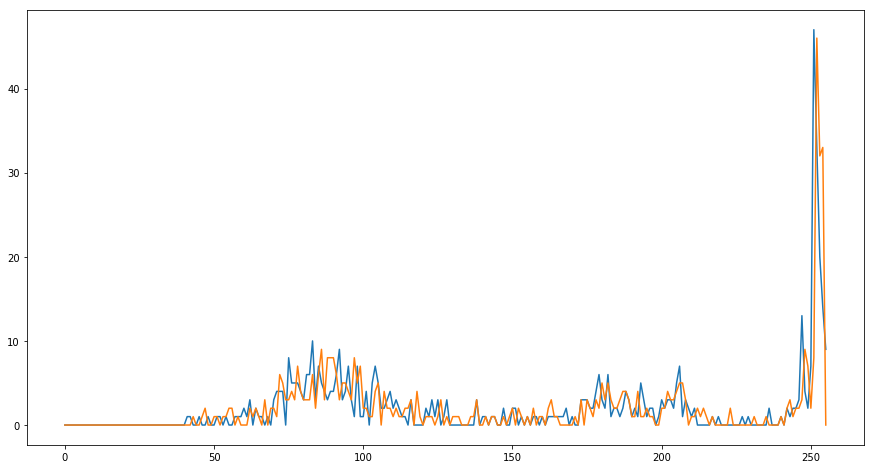

In [44]:
import cv2
fullimage = fullimage.astype(np.float32)
plt.figure(figsize=[15,8])
hist1 = cv2.calcHist([outimage], [0], None, [256], [0,1])
hist2 = cv2.calcHist([fullimage], [0], None, [256], [0,1])
plt.plot(hist1)
plt.plot(hist2)
#plt.xlim([0,1])
